In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.experimental import enable_iterative_imputer

In [2]:
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
train_data.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0000,NaN,S
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S
682,683,0,3,"Olsvigen, Mr. Thor Anderson",male,20.0,0,0,6563,9.2250,NaN,S
295,296,0,1,"Lewy, Mr. Ervin G",male,NaN,0,0,PC 17612,27.7208,NaN,C
232,233,0,2,"Sjostedt, Mr. Ernst Adolf",male,59.0,0,0,237442,13.5000,NaN,S
429,430,1,3,"Pickard, Mr. Berk (Berk Trembisky)",male,32.0,0,0,SOTON/O.Q. 392078,8.0500,E10,S
688,689,0,3,"Fischer, Mr. Eberhard Thelander",male,18.0,0,0,350036,7.7958,NaN,S
685,686,0,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C


In [140]:
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked', 'Name']

X = train_data[features]
y = train_data.Survived
X_test = test_data[features]

In [141]:
#hard coding specific data cleaning for title names and cabin to be used, not ideal to include in pipeline.  Change for both training and test holdout.

#Title cleaning for training data
for dataset in [X, X_test]:
    dataset.loc[:,'Title'] = dataset.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
    dataset.loc[~dataset.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'
    dataset.loc[:,'Title'] = dataset.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
    dataset.loc[~dataset.Title.isin(['Mr', 'Miss', 'Mrs', 'Master']), 'Title'] = 'Other'


title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Other": 5}
for dataset in [X, X_test]:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

X.drop(['Name'], axis=1, inplace = True)
X_test.drop(['Name'], axis=1, inplace = True)

C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [103]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,3,male,22.0,1,0,7.2500,S,1
1,1,female,38.0,1,0,71.2833,C,3
2,3,female,26.0,0,0,7.9250,S,2
3,1,female,35.0,1,0,53.1000,S,3
4,3,male,35.0,0,0,8.0500,S,1


In [104]:
print(X.describe())
print(X_test.describe())
print(X.shape)
print(X_test.shape)

           Pclass         Age       SibSp       Parch        Fare       Title
count  891.000000  714.000000  891.000000  891.000000  891.000000  891.000000
mean     2.308642   29.699118    0.523008    0.381594   32.204208    1.740741
std      0.836071   14.526497    1.102743    0.806057   49.693429    1.052077
min      1.000000    0.420000    0.000000    0.000000    0.000000    1.000000
25%      2.000000   20.125000    0.000000    0.000000    7.910400    1.000000
50%      3.000000   28.000000    0.000000    0.000000   14.454200    1.000000
75%      3.000000   38.000000    1.000000    0.000000   31.000000    2.000000
max      3.000000   80.000000    8.000000    6.000000  512.329200    5.000000
           Pclass         Age       SibSp       Parch        Fare       Title
count  418.000000  332.000000  418.000000  418.000000  417.000000  418.000000
mean     2.265550   30.272590    0.447368    0.392344   35.627188    1.748804
std      0.841838   14.181209    0.896760    0.981429   55.90757

In [142]:
cols = ['Sex', 'Embarked']
X.loc[:,cols] = X.loc[:,cols].astype('category')
X_test.loc[:,cols] = X.loc[:,cols].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    891 non-null    int64   
 1   Sex       891 non-null    category
 2   Age       714 non-null    float64 
 3   SibSp     891 non-null    int64   
 4   Parch     891 non-null    int64   
 5   Fare      891 non-null    float64 
 6   Embarked  889 non-null    category
 7   Title     891 non-null    int64   
dtypes: category(2), float64(2), int64(4)
memory usage: 43.8 KB


In [143]:
data_viz = X.copy() 
data_viz['Survived'] = y

In [144]:
data_viz.groupby(['Title']).Survived.mean().sort_values(ascending = False)

Title
3    0.792000
2    0.697802
4    0.575000
5    0.444444
1    0.156673
Name: Survived, dtype: float64

In [108]:
X.groupby('Title').size()

Title
1    517
2    182
3    125
4     40
5     27
dtype: int64

In [172]:
numeric_transformer = Pipeline(steps=[
    ('imp_num', IterativeImputer(max_iter=10, min_value=0)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imp_cat', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, selector(dtype_exclude="category")),
    ('cat', categorical_transformer, selector(dtype_include="category"))])


classifier = RandomForestClassifier(
                      max_depth=5,
                      n_estimators=500,
                      max_features='auto')

class_model = Pipeline([('preprocess', preprocessor),
                        ('classifier', classifier)])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

class_model.fit(X, y)

print("model score: %.3f" % class_model.score(X, y))

model score: 0.854


In [146]:
X_values = preprocessor.fit_transform(X_train)
onehot_columns = class_model.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names().tolist()
numerical_columns = X.columns[X.dtypes != 'category'].tolist()

df_pipeline = pd.DataFrame(X_values, columns = numerical_columns + list(onehot_columns) )
df_pipeline.head()

,Pclass,Age,SibSp,Parch,Fare,Title,x0_male,x1_Q,x1_S
0,-1.524732,0.662649,-0.496983,-0.473755,0.991861,1.156156,0.0,0.0,0.0
1,0.850780,-0.516961,0.412662,0.713968,-0.224516,0.219656,0.0,0.0,0.0
2,-0.336976,-0.496577,-0.496983,-0.473755,-0.478276,3.029154,1.0,0.0,1.0
3,0.850780,-0.173428,-0.496983,-0.473755,-0.537125,0.219656,0.0,1.0,0.0
4,0.850780,-0.496577,-0.496983,-0.473755,-0.541405,0.219656,0.0,0.0,1.0


In [147]:
import numpy as np
feature_importance = pd.Series(data= class_model.named_steps['classifier'].feature_importances_, index = np.array(numerical_columns + list(onehot_columns)))
feature_importance.sort_values(ascending=False)

x0_male    0.304983
Title      0.234228
Fare       0.141773
Pclass     0.125323
Age        0.092435
SibSp      0.054826
Parch      0.024107
x1_S       0.017046
x1_Q       0.005280
dtype: float64

In [114]:
param_grid = {
    'classifier__max_depth': [3, 5, 8],
    'classifier__n_estimators': [100, 500],
    'classifier__max_features': [2, 7, 'auto']
     }

grid_search = GridSearchCV(class_model, param_grid, cv=8, verbose=0)
grid_search.fit(X_train, y_train)

print(("best random foreest classification from grid search: %.3f"
       % grid_search.score(X_val, y_val)))

best random foreest classification from grid search: 0.821


In [115]:
grid_search.best_params_

{'classifier__max_depth': 5,
 'classifier__max_features': 7,
 'classifier__n_estimators': 100}

In [122]:
y_train_score = cross_val_score(class_model, X_val, y_val, cv=10)
print(y_train_score.mean())
print(y_train_score.std())

0.8035947712418301
0.08673931536470184


In [159]:
y_pred = class_model.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[106,  12],
       [ 18,  43]], dtype=int64)

In [167]:
from yellowbrick.classifier import ConfusionMatrix, ROCAUC

mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    class_model,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_train, y_train)
cm_viz.poof()


ImportError: cannot import name 'LearningCurve' from 'yellowbrick.classifier' (C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\yellowbrick\classifier\__init__.py)

In [161]:
#check the roc_auc
roc_auc_score(y_val, y_pred)

0.8016115587663241

C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\yellowbrick\classifier\base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


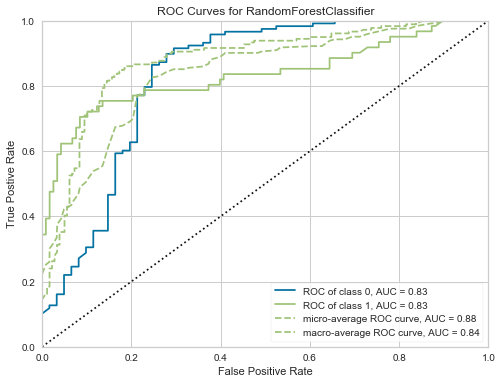

In [166]:
fig, ax = plt.subplots(figsize=(8, 6))
roc_viz = ROCAUC(class_model)
roc_viz.score(X_val, y_val)
roc_viz.poof()

C:\Users\mwilson\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


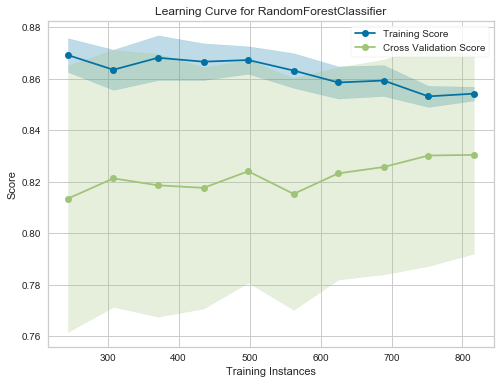

In [170]:
from yellowbrick.model_selection import LearningCurve
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    class_model,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=4,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.poof()


In [173]:
predictions = class_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output = output.astype(int)
output.to_csv('../data/my_submissionFINAL.csv', index=False)